In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


#Functions for human detection and Frames Extraction

In [ ]:
import os
import shutil
import cv2
import numpy as np
import tkinter as tk
from tkinter import filedialog
import warnings
warnings.filterwarnings("ignore")

# Function to detect humans in a frame
def detect_humans(frame, human_cascade):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    humans = human_cascade.detectMultiScale(gray, 1.1, 4)

    for (x, y, w, h) in humans:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

    return frame

def extract_frames_with_human_detection(video_path, output_folder, frame_rate=1):
    if not os.path.exists(video_path):
        print(f"Error: Video file '{video_path}' does not exist.")
        return

    # Clear the output directory if it exists
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
    os.makedirs(output_folder)

    human_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_fullbody.xml')

    video = cv2.VideoCapture(video_path)

    if not video.isOpened():
        print(f"Error: Could not open video '{video_path}'.")
        return

    fps = video.get(cv2.CAP_PROP_FPS)
    interval = int(fps / frame_rate)
    count = 0
    frame_count = 0

    success, frame = video.read()
    while success:
        if count % interval == 0:
            # Detect humans in the frame
            frame_with_humans = detect_humans(frame, human_cascade)
            frame_resized = cv2.resize(frame_with_humans, (150, 150))  # Resize to 150x150
            frame_filename = os.path.join(output_folder, f"{os.path.basename(video_path)}_frame_{frame_count:04d}.jpg")
            cv2.imwrite(frame_filename, frame_resized)
            frame_count += 1

        success, frame = video.read()
        count += 1

    video.release()
    print(f"Number of frames extracted and saved from {video_path}: {frame_count}")

# if __name__ == "__main__":
#     try:
#         # Paths to the folders
#         violence_source_folder = "/content/drive/MyDrive/Real Life Violence Dataset/Violence"
#         nonviolence_source_folder = "/content/drive/MyDrive/Real Life Violence Dataset/NonViolence"
#         extracted_folder = "/content/drive/MyDrive/Real Life Violence Dataset/ExtractedFrames"

#         # Extract frames from up to 150 non-violence videos
#         nonviolence_videos = [os.path.join(nonviolence_source_folder, f) for f in os.listdir(nonviolence_source_folder) if f.endswith(".mp4")][:100]
#         for i, video_path in enumerate(nonviolence_videos):
#             output_dir = os.path.join(extracted_folder, 'NonViolence', f"NV_{i+1:04d}")
#             extract_frames_with_human_detection(video_path, output_dir)

#         # Extract frames from up to 150 violence videos
#         violence_videos = [os.path.join(violence_source_folder, f) for f in os.listdir(violence_source_folder) if f.endswith(".mp4")][:100]
#         for i, video_path in enumerate(violence_videos):
#             output_dir = os.path.join(extracted_folder, 'Violence', f"V_{i+1:04d}")
#             extract_frames_with_human_detection(video_path, output_dir)

#         print("Image Frames Extraction with human detection completed.")

#     except Exception as e:
#         print(f"Error in main execution: {str(e)}")


#Merging the images from seperate extracted violence and nonviolence subdirectories into single directories

In [ ]:
import os
import shutil
import uuid

def merge_directories(source_dir, target_dir):
    try:
        # Create the target directory if it doesn't exist
        if not os.path.exists(target_dir):
            os.makedirs(target_dir)

        # Iterate through subdirectories in the source directory
        for root, dirs, files in os.walk(source_dir):
            for file in files:
                # Generate a unique file name
                unique_filename = str(uuid.uuid4()) + os.path.splitext(file)[1]

                # Copy files to the target directory
                source_path = os.path.join(root, file)
                target_path = os.path.join(target_dir, unique_filename)
                shutil.copyfile(source_path, target_path)

        print(f"Merging completed from '{source_dir}' to '{target_dir}'.")

    except Exception as e:
        print(f"Error merging directories: {str(e)}")


# if __name__ == "__main__":
#     try:
#         # Paths to the folders
#         extracted_violence_folder = "/content/drive/MyDrive/Real Life Violence Dataset/ExtractedFrames/Violence"
#         extracted_nonviolence_folder = "/content/drive/MyDrive/Real Life Violence Dataset/ExtractedFrames/NonViolence"
#         merged_violence_folder = "/content/drive/MyDrive/Real Life Violence Dataset/MergedFrames/Violence"
#         merged_nonviolence_folder = "/content/drive/MyDrive/Real Life Violence Dataset/MergedFrames/NonViolence"

#         # Step 2: Merge extracted frames into a single directory
#         merge_directories(extracted_violence_folder, merged_violence_folder)
#         merge_directories(extracted_nonviolence_folder, merged_nonviolence_folder)

#         print("Merging completed.")

#     except Exception as e:
#         print(f"Error in main execution: {str(e)}")

#Applying image processing and augmentation

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def apply_augmentation(datagen, source_dir, target_dir, num_images=10, save_prefix='aug', save_format='jpg'):
    # Create output directory if it doesn't exist
    os.makedirs(target_dir, exist_ok=True)

    # Load and augment images from source directory
    image_paths = [os.path.join(source_dir, img) for img in os.listdir(source_dir)]

    for img_path in image_paths:
        img = cv2.imread(img_path)
        if img is None:
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = img / 255.0  # Normalize image
        img_rgb = img_rgb[np.newaxis, ...]  # Add batch dimension

        i = 0
        for batch in datagen.flow(img_rgb, batch_size=1, save_to_dir=target_dir,
                                  save_prefix=save_prefix, save_format=save_format):
            i += 1
            if i >= num_images:
                break


# if __name__ == "__main__":
#     try:
#         # Paths to the folders
#         merged_violence_folder = "/content/drive/MyDrive/Real Life Violence Dataset/MergedFrames/Violence"
#         merged_nonviolence_folder = "/content/drive/MyDrive/Real Life Violence Dataset/MergedFrames/NonViolence"
#         augmented_violence_folder = "/content/drive/MyDrive/Real Life Violence Dataset/AugmentedFrames/Violence"
#         augmented_nonviolence_folder = "/content/drive/MyDrive/Real Life Violence Dataset/AugmentedFrames/NonViolence"

#         # Initialize ImageDataGenerator for augmentation
#         datagen = ImageDataGenerator(
#             rotation_range=20,
#             width_shift_range=0.2,
#             height_shift_range=0.2,
#             shear_range=0.2,
#             zoom_range=0.2,
#             horizontal_flip=True,
#             fill_mode='nearest'
#         )

#         # Step 3: Apply image processing and augmentation to merged directories
#         apply_augmentation(datagen, merged_violence_folder, augmented_violence_folder, num_images=10)
#         apply_augmentation(datagen, merged_nonviolence_folder, augmented_nonviolence_folder, num_images=10)

#         print("Image processing and augmentation completed.")

#     except Exception as e:
#         print(f"Error in main execution: {str(e)}")

#Splitting the augmented frames directory into training and validation sets

In [ ]:
import os
import random
import shutil

def split_data_into_train_val(final_data_folder, split_ratio):
    train_folder = os.path.join(final_data_folder, 'train')
    val_folder = os.path.join(final_data_folder, 'val')

    # Create train and val folders if they don't exist
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)

    for class_folder in ['NonViolence', 'Violence']:
        class_path = os.path.join(final_data_folder, class_folder)
        train_class_path = os.path.join(train_folder, class_folder)
        val_class_path = os.path.join(val_folder, class_folder)

        # Create class folders in train and val directories
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(val_class_path, exist_ok=True)

        # List all images in the class folder
        images = os.listdir(class_path)
        random.shuffle(images)  # Shuffle to randomize the split

        # Calculate split index based on split_ratio
        split_idx = int(len(images) * split_ratio)

        # Move images to train folder
        for img in images[:split_idx]:
            src = os.path.join(class_path, img)
            dst = os.path.join(train_class_path, img)
            shutil.copy(src, dst)

        # Move images to validation folder
        for img in images[split_idx:]:
            src = os.path.join(class_path, img)
            dst = os.path.join(val_class_path, img)
            shutil.copy(src, dst)

# Example usage
# final_data_folder = "/content/drive/MyDrive/Real Life Violence Dataset/AugmentedFrames"
# split_ratio = 0.8  # 80% for training, 20% for validation
# split_data_into_train_val(final_data_folder, split_ratio)

#Building and training the model

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def build_and_train_model(final_data_folder, model_save_path):
    try:
        # Initialize ImageDataGenerator for training and validation
        train_datagen = ImageDataGenerator(
            rescale=1./255,
        )

        val_datagen = ImageDataGenerator(
            rescale=1./255
        )

        # Generate training dataset
        train_generator = train_datagen.flow_from_directory(
            os.path.join(final_data_folder, 'train'),
            target_size=(150, 150),
            batch_size=32,
            class_mode='binary'
        )

        # Generate validation dataset
        validation_generator = val_datagen.flow_from_directory(
            os.path.join(final_data_folder, 'val'),
            target_size=(150, 150),
            batch_size=32,
            class_mode='binary'
        )

        # Load pre-trained VGG16 model
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

        # Freeze the layers of the pre-trained model
        for layer in base_model.layers:
            layer.trainable = False

        # Create a new model on top of the pre-trained model
        model = Sequential([
            base_model,
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Print model summary
        model.summary()

        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        # Train the transfer learning model with early stopping
        history = model.fit(
            train_generator,
            steps_per_epoch=len(train_generator),
            epochs=10,
            validation_data=validation_generator,
            validation_steps=len(validation_generator),
            callbacks=[early_stopping]
        )

        # Save the model
        model.save(model_save_path)
        print(f"Model saved to {model_save_path}")

        return model, history

    except Exception as e:
        print(f"Error building and training the model: {str(e)}")
        return None, None

final_data_folder = "/content/drive/MyDrive/Real Life Violence Dataset/AugmentedFrames"
model_save_path = "/content/drive/MyDrive/Real Life Violence Dataset/Violence_Detection_Model.keras"
model, history = build_and_train_model(final_data_folder, model_save_path)

Found 6601 images belonging to 2 classes.
Found 1651 images belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15763521 (60.13 MB)
Train

#Saving the model summary into a csv file

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import re
import pandas as pd

stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
summ_string = "\n".join(stringlist)
print(summ_string) # entire summary in a variable

table = stringlist[1:-4][1::2] # take every other element and remove appendix

new_table = []
for entry in table:
    entry = re.split(r'\s{2,}', entry)[:-1] # remove whitespace
    new_table.append(entry)

df = pd.DataFrame(new_table[1:], columns=new_table[0])
df

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15763521 (60.13 MB)
Trainable params: 15763521 (60.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


,Layer (type),Output Shape,Param #
0,vgg16 (Functional),"(None, 4, 4, 512)",14714688
1,flatten_2 (Flatten),"(None, 8192)",0
2,dense_4 (Dense),"(None, 128)",1048704
3,dropout_2 (Dropout),"(None, 128)",0
4,dense_5 (Dense),"(None, 1)",129
5,None,None,None


#Saving the training and validation performance over the epochs into a csv file

In [ ]:
import pandas as pd
metrics_df=pd.DataFrame(history.history)
metrics_df
# # Save DataFrame to CSV
# csv_file = "/content/drive/MyDrive/Real Life Violence Dataset/model_history.csv"
# metrics_df.to_csv(csv_file, index=False)

# print(f"DataFrame saved as CSV file: {csv_file}")

,loss,accuracy,val_loss,val_accuracy
0,0.202182,0.919558,0.110530,0.959419
1,0.104770,0.962127,0.081647,0.963053
2,0.067055,0.976064,0.065380,0.973955
3,0.050737,0.982730,0.063107,0.973350
4,0.034485,0.988487,0.057184,0.978801
5,0.033151,0.988184,0.060091,0.977589
6,0.022908,0.992425,0.050392,0.983646
7,0.022802,0.991668,0.059181,0.982435
8,0.022972,0.991213,0.054688,0.981829
9,0.014992,0.994546,0.077365,0.979406


#AUC-ROC curve

Found 6601 images belonging to 2 classes.
Found 1651 images belonging to 2 classes.
52/52 [==============================] - 415s 8s/step


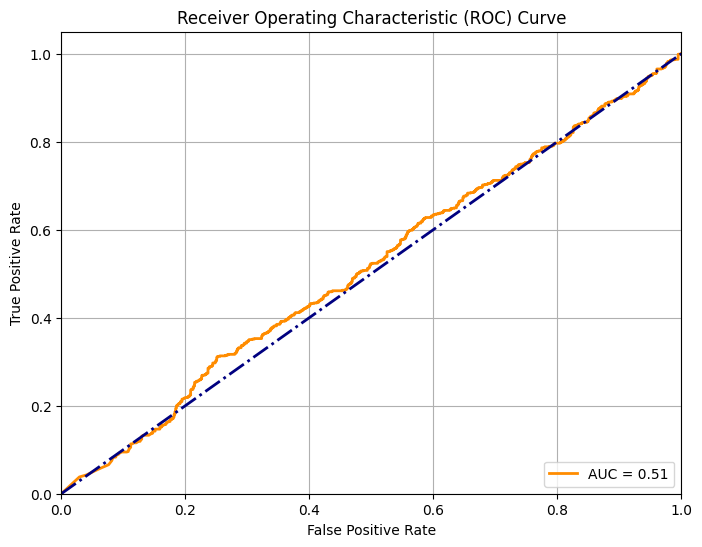

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Initialize ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

# Generate training dataset
train_generator = train_datagen.flow_from_directory(
    os.path.join(final_data_folder, 'train'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Generate validation dataset
validation_generator = val_datagen.flow_from_directory(
    os.path.join(final_data_folder, 'val'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Predict probabilities for validation set
y_pred_proba = model.predict(validation_generator).ravel()

# Compute ROC curve and AUC area for each class
fpr, tpr, _ = roc_curve(validation_generator.classes, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='dashdot')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#Plotting the learning over the epochs and generating the confusion matrix and classification report

Found 6601 images belonging to 2 classes.
Found 1651 images belonging to 2 classes.


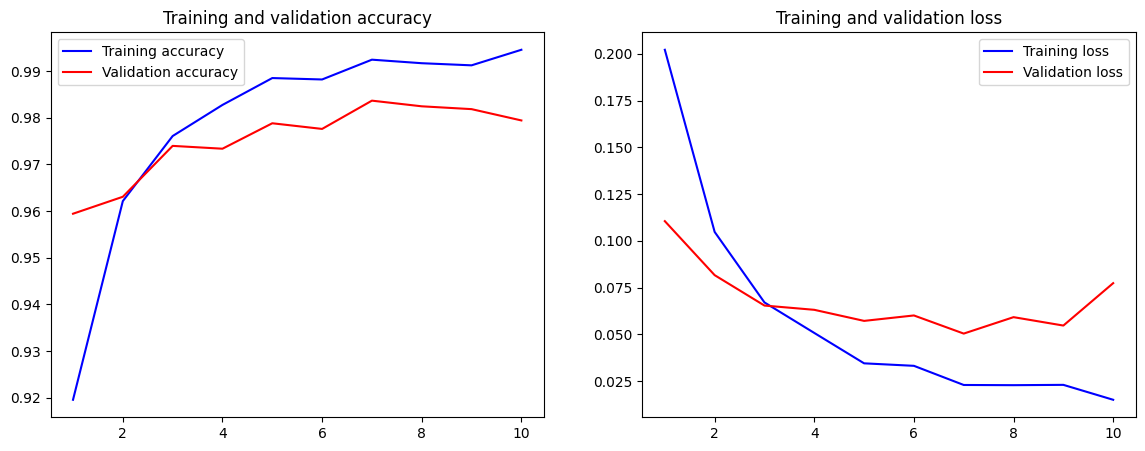

52/52 [==============================] - 391s 8s/step - loss: 0.0504 - accuracy: 0.9836
Training Loss: 0.005192113108932972
Training Accuracy: 0.9986365437507629
Validation Loss: 0.05039171501994133
Validation Accuracy: 0.9836462736129761
52/52 [==============================] - 389s 7s/step
Confusion Matrix:
[[767  19]
 [  8 857]]


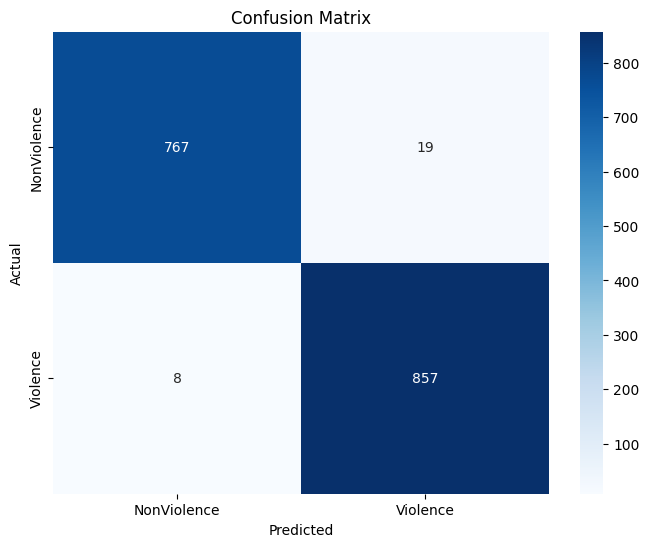


Classification Report:
              precision    recall  f1-score   support

 NonViolence       0.99      0.98      0.98       786
    Violence       0.98      0.99      0.98       865

    accuracy                           0.98      1651
   macro avg       0.98      0.98      0.98      1651
weighted avg       0.98      0.98      0.98      1651



In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def plot_metrics(history, model, train_generator, validation_generator):
    # Plot training and validation accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    # Evaluate the model on training and validation data
    train_loss, train_accuracy = model.evaluate(train_generator)
    val_loss, val_accuracy = model.evaluate(validation_generator)

    print("Training Loss:", train_loss)
    print("Training Accuracy:", train_accuracy)
    print("Validation Loss:", val_loss)
    print("Validation Accuracy:", val_accuracy)

def evaluate_model(model, validation_generator):
    y_true = validation_generator.classes
    y_pred = model.predict(validation_generator).squeeze().round().astype(int)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    target_names = validation_generator.class_indices.keys()
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))

if __name__ == "__main__":
    final_data_folder = "/content/drive/MyDrive/Real Life Violence Dataset/AugmentedFrames"
    model_save_path = "/content/drive/MyDrive/Real Life Violence Dataset/Violence_Detection_Model.keras"

    # Load the saved model
    model = load_model(model_save_path)

    # Initialize ImageDataGenerator for training and validation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
    )

    val_datagen = ImageDataGenerator(
        rescale=1./255
    )

    # Generate training dataset
    train_generator = train_datagen.flow_from_directory(
        os.path.join(final_data_folder, 'train'),
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary'
    )

    # Generate validation dataset
    validation_generator = val_datagen.flow_from_directory(
        os.path.join(final_data_folder, 'val'),
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        shuffle=False  # Important to set shuffle to False to maintain consistency
    )

    # Assuming `history` and `validation_generator` are available from the previous execution
    # Plot training and validation metrics
    plot_metrics(history, model, train_generator, validation_generator)

    # Evaluate model performance
    evaluate_model(model, validation_generator)

#Testing our model on a sample video

In [ ]:
from google.colab import drive
import os
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import cv2
import shutil

# Function to extract frames with human detection
def extract_frames_with_human_detection(video_path, output_folder, frame_rate=1):
    if not os.path.exists(video_path):
        print(f"Error: Video file '{video_path}' does not exist.")
        return 0

    # Clear the output directory if it exists
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
    os.makedirs(output_folder)

    # Load Haar cascade classifier for full body detection
    human_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_fullbody.xml')

    # Open the video file
    video = cv2.VideoCapture(video_path)

    if not video.isOpened():
        print(f"Error: Could not open video '{video_path}'.")
        return 0

    fps = video.get(cv2.CAP_PROP_FPS)
    interval = int(fps / frame_rate)
    count = 0
    frame_count = 0

    success, frame = video.read()
    while success:
        if count % interval == 0:
            # Detect humans in the frame
            frame_with_humans = detect_humans(frame, human_cascade)
            frame_resized = cv2.resize(frame_with_humans, (150, 150))  # Resize to 150x150
            frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
            cv2.imwrite(frame_filename, frame_resized)
            frame_count += 1

        success, frame = video.read()
        count += 1

    video.release()
    print(f"Number of frames extracted and saved from {video_path}: {frame_count}")
    return frame_count

# Function to detect humans in a frame
def detect_humans(frame, human_cascade):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    humans = human_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    for (x, y, w, h) in humans:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
    return frame

# Function to select a test video path
def select_test_video(dataset_root):
    try:
        print("Enter the path of a video from the Real Life Violence Dataset:")
        video_path = input().strip()

        video_full_path = os.path.join(dataset_root, video_path)

        if not os.path.exists(video_full_path):
            print(f"Error: File '{video_path}' not found in Real Life Violence Dataset.")
            return None

        print(f"Selected test video: {video_full_path}")
        return video_full_path

    except Exception as e:
        print(f"Error selecting test video: {str(e)}")
        return None

# Function to load and process an image
def load_and_process_image(image_path, target_size=(150, 150)):
    try:
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        return img_array
    except Exception as e:
        print(f"Error loading image '{image_path}': {str(e)}")
        return None

# Custom predict function using your own logic
def predict_video_class(model, sample_image, threshold=0.5):
    try:
        video_class_prob = model.predict(sample_image)

        if video_class_prob is not None:
            video_class = 1 if video_class_prob > threshold else 0
            return video_class
        else:
            print("Error: Unable to predict video class.")
            return None

    except Exception as e:
        print(f"Error predicting video class: {str(e)}")
        return None

if __name__ == "__main__":
    try:
        # Mount Google Drive if not already mounted
        if not os.path.exists('/content/drive/'):
            drive.mount('/content/drive')

        # Define paths and model
        dataset_root = '/content/drive/My Drive/Real Life Violence Dataset/'
        model_save_path = os.path.join(dataset_root, 'Violence_Detection_Model.keras')

        # Load pre-trained model
        model = load_model(model_save_path)

        # Select test video
        test_video_path = select_test_video(dataset_root)
        if not test_video_path:
            raise ValueError("No test video selected or invalid path.")

        # Create folder for storing frames
        test_frames_folder = '/content/test_frames'
        os.makedirs(test_frames_folder, exist_ok=True)

        # Extract frames from video with human detection
        num_frames = extract_frames_with_human_detection(test_video_path, test_frames_folder)

        if num_frames > 0:
            # Load and process a sample frame
            sample_frame_path = os.path.join(test_frames_folder, 'frame_0000.jpg')
            sample_image = load_and_process_image(sample_frame_path)

            if sample_image is not None:
                # Predict video class using custom predict function
                video_class = predict_video_class(model, sample_image)

                if video_class is not None:
                    if video_class == 1:
                        print("The video is classified as violent.")
                    else:
                        print("The video is classified as non-violent.")
                else:
                    print("Error: Unable to classify the video.")
            else:
                print("Error: Unable to load and process the sample image.")

    except Exception as e:
        print(f"Error in main execution: {str(e)}")

Enter the path of a video from the Real Life Violence Dataset:
/content/drive/MyDrive/Real Life Violence Dataset/Violence/V_101.mp4
Selected test video: /content/drive/MyDrive/Real Life Violence Dataset/Violence/V_101.mp4
Number of frames extracted and saved from /content/drive/MyDrive/Real Life Violence Dataset/Violence/V_101.mp4: 4
1/1 [==============================] - 0s 346ms/step
The video is classified as violent.
